In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import multiprocessing
from scipy.stats import gaussian_kde
from scipy.stats import norm, truncnorm, beta
#from copy import copy
from itertools import repeat
from tqdm import tqdm
from time import time

import pandas as pd
import os
import random
import numpy as np
import sys
lib_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(""))), "models")


sys.path.append(lib_path)

from model_age_stratified import Model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
age_groups = np.array([3076945, 9980931, 33030917, 10401308])
age_props = age_groups/56490101
print(age_props)
pop= 1e6
y1_0 = np.array([[0,0,0,0],
                  [0,0,1,0],
                  [0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0]])
y1_0[0, :] = age_props*pop # for now 
print(y1_0)

[0.05446875 0.1766846  0.58472045 0.18412621]
[[ 54468 176684 584720 184126]
 [     0      0      1      0]
 [     0      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]]


In [6]:
flight_df = pd.read_csv(os.path.join("..", "..", "data", "processed", "country_flights.csv"))
flight_df

,Unnamed: 0,Name,Seats,Country Code,Population
0,0,United Kingdom,2042755,GBR,67326569.0
1,1,Spain,1542659,ESP,47415750.0
2,2,USA,995647,USA,331893745.0
3,3,Italy,650027,ITA,59109668.0
4,4,Germany,578800,DEU,83196078.0
...,...,...,...,...,...
90,90,Cuba,1200,CUB,11256372.0
91,91,Senegal,756,SEN,16876720.0
92,92,Aruba,672,ABW,106537.0
93,93,Guyana,672,GUY,804567.0


In [7]:
# ATM assuming that the arriving and departing number of seat is symmetric as only have incoming flights to UK 
source_country = 'Spain'
seats, pop = flight_df.loc[flight_df['Name'] == source_country, ['Seats', 'Population']].values[0]
seats //= 31 # get average number of seats per day
print(seats, pop)

49763.0 47415750.0


[[0.375 0.375 0.375 0.375]
 [0.375 0.375 0.375 0.375]
 [0.375 0.375 0.375 0.375]
 [0.375 0.375 0.375 0.375]]


/Users/neythen/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


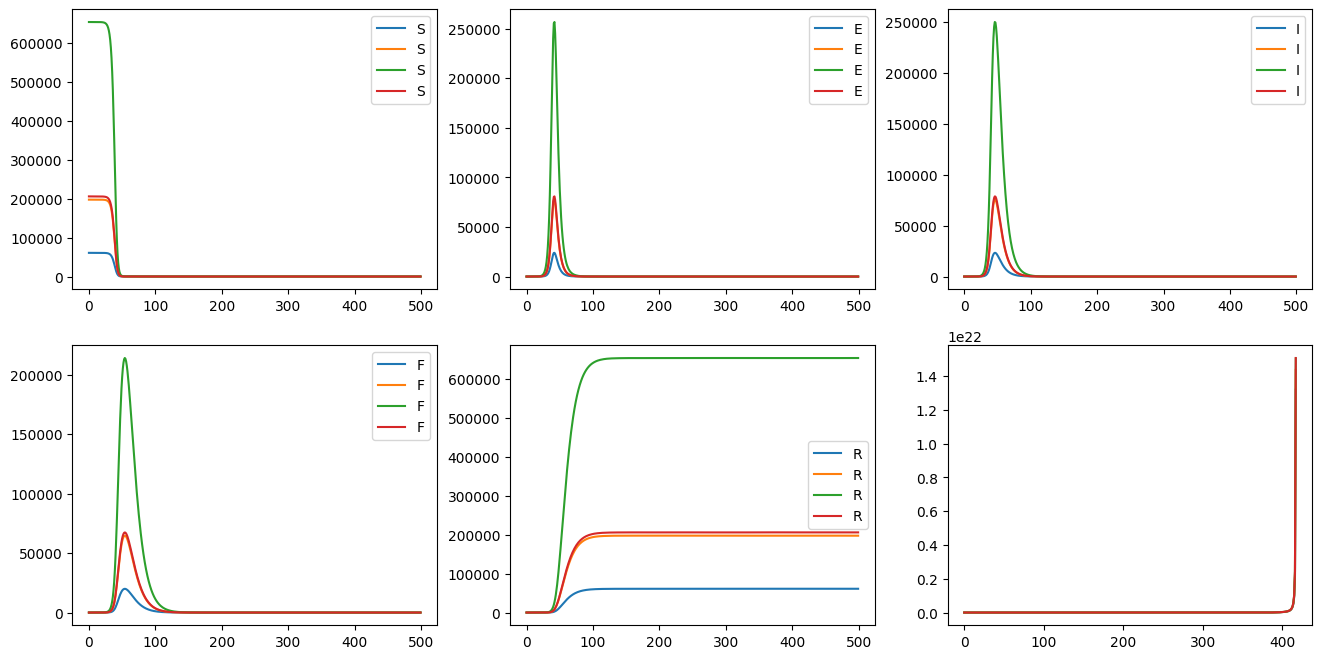

In [15]:

#sim = Model(y1_0=[pop,1,0,0,0,0], n=int(seats))
for i in range(1):
    sim =Model()
    sim.simulate()
    print(sim.params['beta'])
    total_IF = np.array(sim.IF_timeseries).sum(axis=1)
    
    t_seeded = np.argmax(total_IF > 0) if np.sum(total_IF > 0) > 0 else len(total_IF)-1

    t_detected = sim.wd_timeseries.index(1) if 1 in sim.wd_timeseries else len(sim.wd_timeseries)-1
    t_screened = sim.bd_timeseries.index(1) if 1 in sim.bd_timeseries else len(sim.bd_timeseries)-1
    t_screened_h = sim.hd_timeseries.index(1) if 1 in sim.hd_timeseries else len(sim.hd_timeseries)-1
    t_screened_c = sim.cd_timeseries.index(1) if 1 in sim.cd_timeseries else len(sim.cd_timeseries)-1


    t_screened_sh = sim.hs_timeseries.index(1) if 1 in sim.hs_timeseries else len(sim.hs_timeseries)-1
    t_screen_sc = sim.cs_timeseries.index(1) if 1 in sim.cs_timeseries else len(sim.cs_timeseries)-1

    if False:
        print(t_screened_h-t_seeded)
        print(t_seeded, t_screened_h)
        
        for i in range(len(sim.hd_timeseries)):
            print()
            print(i)
            print('hd:', sim.hd_timeseries[i])
            print('if:', sim.IF_timeseries[i])
            print('s:', sim.solution_1[i][0])
            print('e:', sim.solution_1[i][1])
            print('i:', sim.solution_1[i][2])
            print('ci:', sim.solution_1[i][-1])
            
     
            
        print()
    labels = ['S','E','I','F','R']
    fig, axs = plt.subplots(2,3, figsize=(16,8))
    
    for i in range(len(labels)):
        axs[i//3][i%3].plot(np.array(sim.solution_1)[:,i], label = labels[i])
        axs[i//3][i%3].legend()
        
    axs[1][2].plot(sim.c_hosp/np.array(sim.solution_1)[:,2])
        
        

NameError: name 't_screened_sc' is not defined

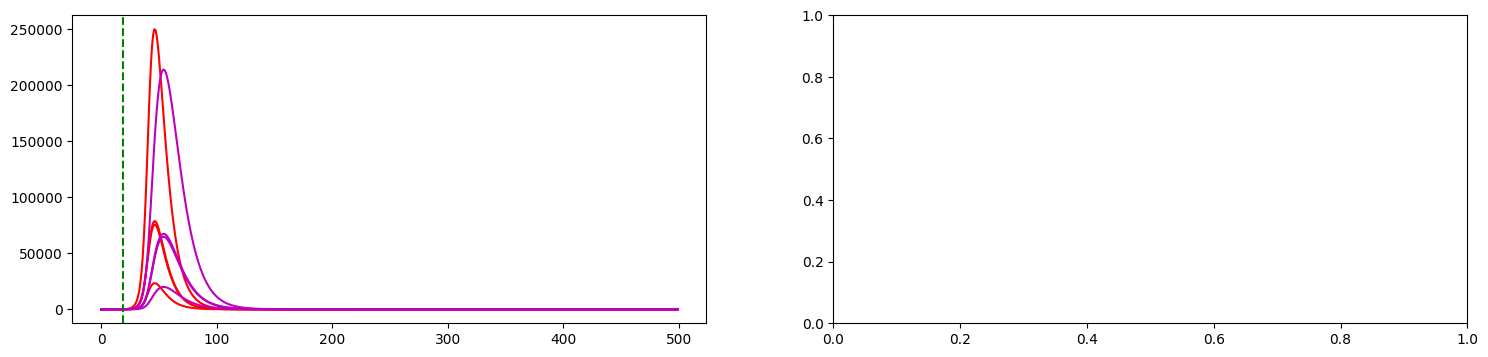

In [16]:
fig, ax = plt.subplots(1,2, figsize=(18,4))
#ax[0].plot(sim.t_steps[:-1], [x[0] for x in sim.solution_1], 'b', label='S')
#ax[0].plot(sim.t_steps[:-1], [x[1] for x in sim.solution_1], 'g', label='E')
ax[0].plot(sim.t_steps[:-1], [x[2] for x in sim.solution_1], 'r', label='I')
ax[0].plot(sim.t_steps[:-1], [x[3] for x in sim.solution_1], 'm', label='F')
ax[0].axvline(t_screened_sh, color='g', ls='--', label='Hospital screening Detected')
ax[0].axvline(t_screened_sc, color='c', ls='--', label='Community screening Detected')
#ax[0].plot(sim.t_steps[:-1], [x[4] for x in sim.solution_1], 'y', label='R')

#ax[1].plot(sim.t_steps[:-1], [x[0] for x in sim.solution_2], 'b')
#ax[1].plot(sim.t_steps[:-1], [x[1] for x in sim.solution_2], 'g')
ax[1].plot(sim.t_steps[:-1], [x[2] for x in sim.solution_2], 'r')
ax[1].plot(sim.t_steps[:-1], [x[3] for x in sim.solution_2], 'm')
#ax[1].plot(sim.t_steps[:-1], [x[4] for x in sim.solution_2], 'y')

ax[1].axvline(t_seeded, color='r', ls='--', label='Seeded')
ax[1].axvline(t_detected, color='k', ls='--', label='Wastewater Detected')
ax[1].axvline(t_screened, color='b', ls='--', label='Border screening Detected')
ax[1].axvline(t_screened_h, color='g', ls='--', label='Hospital screening Detected')
ax[1].axvline(t_screened_c, color='c', ls='--', label='Community screening Detected')

ax[0].set_title('Seed Country')
ax[1].set_title('UK')

ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[0].set_ylabel('N')

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')

ax[0].legend()
ax[1].legend(loc='upper right')

In [17]:
t_seed = []
t_detect = []
t_screen = []
It_detect = []
It_screen = []
ps_mu = 0.459
ps_sig2 = 0.168**2
ps_alpha = ((1-ps_mu)/ps_sig2 - 1/ps_mu)*ps_mu**2
ps_beta = ps_alpha*((1/ps_mu) -1)


params = []
# make parameter set generator object
param_generator = ({'pd':random.uniform(0.1,0.6),
                    'n':random.randint(100,400),
                    'ps':beta(ps_alpha, ps_beta).rvs(),
                    'delta':1/random.uniform(3,28),
                    'phi':0.2,
                    'eta':0.85} for i in range(10000))

MC_results = []
t = time()
# create a process pool that uses all cpus
for i in range(1000):
    print(i)
    params = next(param_generator)
    
    sim = Model(**params)
    sim.simulate()
    
    
    t_seed = [t for t,p in enumerate(sim.IF_timeseries) if p>0][0]
    
    # get time of detections
    t_detect = [t for t,p in enumerate(sim.ww_timeseries) if p==1][0]
    t_screen = [t for t,p in enumerate(sim.rs_timeseries) if p==1][0]
    t_screen_h = [t for t,p in enumerate(sim.hs_timeseries) if p==1][0]
    t_screen_c = [t for t,p in enumerate(sim.cs_timeseries) if p==1][0]
    
    # get culmulative infections at detection
    c_detect = sim.solution_2[t_detect][-1]
    c_screen = sim.solution_2[t_screen][-1]
    c_screen_h = sim.solution_2[t_screen_h][-1]
    c_screen_c = sim.solution_2[t_screen_c][-1]
    
    # get culmulative number of tests done at detection
    n_detect = sim.ww_count[t_detect]
    n_screen = sim.rs_count[t_screen]
    n_screen_h = sim.hs_count[t_screen_h]
    n_screen_c = sim.cs_count[t_screen_c]

    results_dict = dict(simulation=i,seed_t=t_seed, ww_time=t_detect, bs_time=t_screen, hs_time=t_screen_h, cs_time=t_screen_c, 
                           ww_c_infected=c_detect, bs_c_infected=c_screen, hs_c_infected=c_screen_h, cs_c_infected=c_screen_c,
                           ww_n_tests=n_detect, bs_n_tests=n_screen, hs_n_tests=n_screen_h, cs_n_tests=n_screen_c)
    results_dict.update(params)
    MC_results.append(results_dict)
    
print('time:', time()-t) # 1000 samples takes 9 mins on frontier, 7 minutes on macbook



0


TypeError: type object got multiple values for keyword argument 'phi'

In [18]:
# PLOT RESULTS
t_seed = [res['seed_t'] for res in MC_results]
sq05, sq25, sq50, sq75, sq95 = np.quantile(t_seed, [0.05, 0.25, 0.5, 0.75, 0.95])
t_detect = [res['ww_time'] for res in MC_results]
wq05, wq25, wq50, wq75, wq95 = np.quantile(t_detect, [0.05, 0.25, 0.5, 0.75, 0.95])
t_screen_b = [res['bs_time'] for res in MC_results]
bq05, bq25, bq50, bq75, bq95 = np.quantile(t_screen_b, [0.05, 0.25, 0.5, 0.75, 0.95])
t_screen_h = [res['hs_time'] for res in MC_results]
hq05, hq25, hq50, hq75, hq95 = np.quantile(t_screen_h, [0.05, 0.25, 0.5, 0.75, 0.95])
t_screen_c = [res['cs_time'] for res in MC_results]
cq05, cq25, cq50, cq75, cq95 = np.quantile(t_screen_c, [0.05, 0.25, 0.5, 0.75, 0.95])
# seed kde
seed_kde = gaussian_kde(t_seed)
seed_kde.covariance_factor = lambda : .25
seed_kde._compute_covariance()
# detect kde
detect_kde = gaussian_kde(t_detect)
detect_kde.covariance_factor = lambda : .25
detect_kde._compute_covariance()
# screen kde
screen_b_kde = gaussian_kde(t_screen_b)
screen_b_kde.covariance_factor = lambda : .25
screen_b_kde._compute_covariance()

screen_h_kde = gaussian_kde(t_screen_h)
screen_h_kde.covariance_factor = lambda : .25
screen_h_kde._compute_covariance()

screen_c_kde = gaussian_kde(t_screen_c)
screen_c_kde.covariance_factor = lambda : .25
screen_c_kde._compute_covariance()

X = np.linspace(20,130,200)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(X, seed_kde(X), color='k', ls='-', alpha=0.5, label='First incursion into UK')
ax.plot(X, detect_kde(X), color='C0', ls='-', alpha=0.5, label='Wastewater detection')
ax.plot(X, screen_b_kde(X), color='C1', ls='-', alpha=0.5, label='Border swab')
ax.plot(X, screen_h_kde(X), color='C2', ls='-', alpha=0.5, label='Hospital swab')
ax.plot(X, screen_c_kde(X), color='C3', ls='-', alpha=0.5, label='Community swab')

ax.fill_between(X, seed_kde(X), color='k', alpha=0.2)
ax.fill_between(X, detect_kde(X), color='C0', alpha=0.2)
ax.fill_between(X, screen_b_kde(X), color='C1', alpha=0.2)
ax.fill_between(X, screen_h_kde(X), color='C2', alpha=0.2)
ax.fill_between(X, screen_c_kde(X), color='C3', alpha=0.2)

ax.axvline(sq50, color='k',ls='--',lw=3, label=f'Median = {sq50} days')
ax.axvline(wq50, color='C0',ls='--',lw=3, label=f'Median = {wq50} days')
ax.axvline(bq50, color='C1',ls='--', lw=3,label=f'Median = {bq50} days')
ax.axvline(hq50, color='C2',ls='--', lw=3,label=f'Median = {hq50} days')
ax.axvline(cq50, color='C3',ls='--', lw=3,label=f'Median = {cq50} days')

ax.set_ylabel('Density')
ax.set_xlabel('Days since index case in seed country')
ax.legend()

fig.tight_layout()
fig.savefig('fig1.png', dpi=400)
fig.savefig('fig1.pdf')

IndexError: index -1 is out of bounds for axis 0 with size 0

In [19]:
phis = [0.1, 0.2, 0.3, 0.4, 0.5]
phi_hs = [0.1, 0.2, 0.3, 0.4, 0.5]


In [20]:

# PLOT RESULTS
t_seed = [res['seed_t'] for res in MC_results]
sq05, sq25, sq50, sq75, sq95 = np.quantile(t_seed, [0.05, 0.25, 0.5, 0.75, 0.95])
t_detect = [res['ww_time'] for res in MC_results]
wq05, wq25, wq50, wq75, wq95 = np.quantile(t_detect, [0.05, 0.25, 0.5, 0.75, 0.95])
t_screen_b = [res['bs_time'] for res in MC_results]
bq05, bq25, bq50, bq75, bq95 = np.quantile(t_screen_b, [0.05, 0.25, 0.5, 0.75, 0.95])
t_screen_h = [res['hs_time'] for res in MC_results]
hq05, hq25, hq50, hq75, hq95 = np.quantile(t_screen_h, [0.05, 0.25, 0.5, 0.75, 0.95])
t_screen_c = [res['cs_time'] for res in MC_results]
cq05, cq25, cq50, cq75, cq95 = np.quantile(t_screen_c, [0.05, 0.25, 0.5, 0.75, 0.95])
# seed kde
seed_kde = gaussian_kde(t_seed)
seed_kde.covariance_factor = lambda : .25
seed_kde._compute_covariance()
# detect kde
detect_kde = gaussian_kde(t_detect)
detect_kde.covariance_factor = lambda : .25
detect_kde._compute_covariance()
# screen kde
screen_b_kde = gaussian_kde(t_screen_b)
screen_b_kde.covariance_factor = lambda : .25
screen_b_kde._compute_covariance()

screen_h_kde = gaussian_kde(t_screen_h)
screen_h_kde.covariance_factor = lambda : .25
screen_h_kde._compute_covariance()

screen_c_kde = gaussian_kde(t_screen_c)
screen_c_kde.covariance_factor = lambda : .25
screen_c_kde._compute_covariance()

X = np.linspace(20,130,200)

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(X, seed_kde(X), color='k', ls='-', alpha=0.5, label='First incursion into UK')
ax.plot(X, detect_kde(X), color='C0', ls='-', alpha=0.5, label='Wastewater detection')
ax.plot(X, screen_b_kde(X), color='C1', ls='-', alpha=0.5, label='Border swab')
ax.plot(X, screen_h_kde(X), color='C2', ls='-', alpha=0.5, label='Hospital swab')
ax.plot(X, screen_c_kde(X), color='C3', ls='-', alpha=0.5, label='Community swab')

ax.fill_between(X, seed_kde(X), color='k', alpha=0.2)
ax.fill_between(X, detect_kde(X), color='C0', alpha=0.2)
ax.fill_between(X, screen_b_kde(X), color='C1', alpha=0.2)
ax.fill_between(X, screen_h_kde(X), color='C2', alpha=0.2)
ax.fill_between(X, screen_c_kde(X), color='C3', alpha=0.2)

ax.axvline(sq50, color='k',ls='--',lw=3, label=f'Median = {sq50} days')
ax.axvline(wq50, color='C0',ls='--',lw=3, label=f'Median = {wq50} days')
ax.axvline(bq50, color='C1',ls='--', lw=3,label=f'Median = {bq50} days')
ax.axvline(hq50, color='C2',ls='--', lw=3,label=f'Median = {hq50} days')
ax.axvline(cq50, color='C3',ls='--', lw=3,label=f'Median = {cq50} days')

ax.set_ylabel('Density')
ax.set_xlabel('Days since index case in seed country')
ax.legend()

fig.tight_layout()
fig.savefig('fig1.png', dpi=400)
fig.savefig('fig1.pdf')




IndexError: index -1 is out of bounds for axis 0 with size 0